# scATAC-seq preprocessing using pycisTopic

# TODO: figure out naming convention
# TODO: start from creating a cistopic obj
debugging export_pseudobulk: following this github issue https://github.com/aertslab/pycisTopic/issues/117

for multiple samples, please see https://github.com/aertslab/pycisTopic/blob/main/notebooks/Cortex_pycisTopic.ipynb

further reading: https://scenicplus.readthedocs.io/en/latest/pbmc_multiome_tutorial.html#scATAC-seq-preprocessing-using-pycisTopic

In [2]:
import os
import warnings
warnings.simplefilter(action='ignore')
import pickle

import pandas as pd
import scanpy as sc
import scatac_fragment_tools
import scrublet as scr

import pyranges as pr
import pycisTopic

from pycisTopic.pseudobulk_peak_calling import *
from pycisTopic.iterative_peak_calling import *
from pycisTopic.qc import *

from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.topic_qc import *

from loomxpy.loomxpy import SCopeLoom

In [3]:
%matplotlib inline

In [ ]:
import pycisTopic
pycisTopic.__version__

In [4]:
work_dir = "./data/scenicplus/"
tmp_dir = '/scratch/st-dg0ldo-1/akrenip/tmp/ray_spill/'

In [5]:
dataset_suffix = "_e12_e14_GSE178546"

In [6]:
fragments_path = work_dir + '/data/'

fragments_dict = {
    'e12_GSE178546': fragments_path + 'GSM5393630_E12_snATAC_fragments.tsv.gz',
    'e13_GSE178546': fragments_path + 'GSM5393631_E13_snATAC_fragments.tsv.gz',
    'e14_GSE178546': fragments_path + 'GSM5393632_E14_snATAC_fragments.tsv.gz'
}

### Get chromosome sizes for mm10

Note: This was done in-console, because Sockeye notebooks do not have internet connection. 

The following was pasted in-console

```
# Get chromosome sizes (for mm10 here)
import pyranges as pr
import requests
import pandas as pd

target_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes = pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns = ['Chromosome', 'End']
chromsizes['Start'] = [0]*chromsizes.shape[0]
chromsizes = chromsizes.loc[:,['Chromosome', 'Start', 'End']]

# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('_random', '') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x]+'.1' if 'chr' not in chromsizes['Chromosome'][x] else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]

chromsizes=pr.PyRanges(chromsizes)

# exporting
chromsizes.to_csv('/scratch/st-dg0ldo-1/akrenip/jupyter_new/scenicplus/scATAC/chromsizes.csv')
```
To import the created `chromsizes` PyRanges object: 

```
df = pd.read_csv('/scratch/st-dg0ldo-1/akrenip/jupyter_new/scenicplus/scATAC/chromsizes.csv')
chromsizes = pr.PyRanges(df)
del df
```

In [ ]:
# import chromosome sizes PyRanges object 
df = pd.read_csv(work_dir + "chromsizes.csv")
chromsizes = pr.PyRanges(df)
del df

In [ ]:
chromsizes

# 1. Create pseudobulk profiles from cell annotations
Cell annotations are those previously defined in the scRNA-seq notebook. 

### Please note: The imported dataframe will be modified in the following ways: 
1. The `sample_id` column specifies the cell's original timepoint (e.g. "e12_GSE178546"). This column must match keys in the `fragment_dict` object. Taken from the original, imported index. 
2. A new `barcode` column is a copy of the index's barcode info only (e.g. GATGATCCATTTGTTC-1). Taken from the original, imported index.
3. The **index** is renamed according to [Scenic+ tutorial](https://github.com/aertslab/pycisTopic/blob/main/notebooks/Cortex_pycisTopic.ipynb) naming convention with *3 underscores*: BARCODE___SAMPLE (e.g. ATGTCTGATAGA-1___e12_GSE178546).
    - This is just some string rearranging from the original SAMPLE_BARCODE convention, no actual info is changed nor lost!
4. Remove round parentheses from `celltype` entries. Avoids a macs2 error for unexpected '(' and ')'.

In [13]:
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata_combined{}.h5ad'.format(dataset_suffix)))
cell_data = adata.obs
# celltype column must be str datatype, avoids export_pseudobulk function error
adata.obs['celltype'] = adata.obs['celltype'].astype(str) 
# del(adata)

In [14]:
# create new sample_id based on index
adata.obs['sample_id'] = adata.obs.index.str.rsplit("_", n=1).str[0]

# create new barcode based on index
adata.obs['barcode'] = adata.obs.index.str.rsplit("_", n=1).str[1]

In [15]:
# set the index according to the Scenic+ tutorial
adata.obs.index = adata.obs['barcode'] + "___" + adata.obs['sample_id']

In [16]:
adata.obs['celltype'] = adata.obs['celltype'].str.replace('[()]', '', regex=True)

In [17]:
adata.obs.head()

orig.ident  nCount_ATAC  nFeature_ATAC  \
GATGATCCATTTGTTC-1___e12_GSE178546  SeuratProject      12102.0          10120   
GCATTGAGTTTAAGCC-1___e12_GSE178546  SeuratProject      18322.0          14913   
TGGTCCTCACCGATCG-1___e12_GSE178546  SeuratProject      15248.0          12251   
AATACGCCAAGTCCTA-1___e12_GSE178546  SeuratProject      36732.0          25576   
TGAGTCAGTGGAAGCT-1___e12_GSE178546  SeuratProject      47418.0          31790   

                                    nucleosome_signal  nucleosome_percentile  \
GATGATCCATTTGTTC-1___e12_GSE178546           0.796988                   0.75   
GCATTGAGTTTAAGCC-1___e12_GSE178546           0.887329                   0.90   
TGGTCCTCACCGATCG-1___e12_GSE178546           0.671594                   0.34   
AATACGCCAAGTCCTA-1___e12_GSE178546           0.654058                   0.27   
TGAGTCAGTGGAAGCT-1___e12_GSE178546           0.747959                   0.62   

                                   nucleosome_group  TSS.enrichment  \
GATGATCCATTTGTTC-1___e12_GSE178546           NS < 4        7.432567   
GCATTGAGTTTAAGCC-1___e12_GSE178546           NS < 4        6.054323   
TGGTCCTCACCGATCG-1___e12_GSE178546           NS < 4        6.343656   
AATACGCCAAGTCCTA-1___e12_GSE178546           NS < 4        5.724558   
TGAGTCAGTGGAAGCT-1___e12_GSE178546           NS < 4        5.262685   

                                    TSS.percentile high.tss  fragments  ...  \
GATGATCCATTTGTTC-1___e12_GSE178546            0.84     High    16477.0  ...   
GCATTGAGTTTAAGCC-1___e12_GSE178546            0.25     High    26800.0  ...   
TGGTCCTCACCGATCG-1___e12_GSE178546            0.38     High    20705.0  ...   
AATACGCCAAGTCCTA-1___e12_GSE178546            0.14     High    61754.0  ...   
TGAGTCAGTGGAAGCT-1___e12_GSE178546            0.07     High    68602.0  ...   

                                    doublet_score  predicted_doublet  \
GATGATCCATTTGTTC-1___e12_GSE178546       0.033249              False   
GCATTGAGTTTAAGCC-1___e12_GSE178546       0.101558              False   
TGGTCCTCACCGATCG-1___e12_GSE178546       0.058866              False   
AATACGCCAAGTCCTA-1___e12_GSE178546       0.069076              False   
TGAGTCAGTGGAAGCT-1___e12_GSE178546       0.161545              False   

                                    n_genes_by_counts  total_counts  \
GATGATCCATTTGTTC-1___e12_GSE178546               6054       10475.0   
GCATTGAGTTTAAGCC-1___e12_GSE178546               8271       16332.0   
TGGTCCTCACCGATCG-1___e12_GSE178546               7028       12986.0   
AATACGCCAAGTCCTA-1___e12_GSE178546              11528       36204.0   
TGAGTCAGTGGAAGCT-1___e12_GSE178546              12563       43111.0   

                                   total_counts_mt pct_counts_mt leiden  \
GATGATCCATTTGTTC-1___e12_GSE178546             0.0           0.0      1   
GCATTGAGTTTAAGCC-1___e12_GSE178546             0.0           0.0      3   
TGGTCCTCACCGATCG-1___e12_GSE178546             0.0           0.0      1   
AATACGCCAAGTCCTA-1___e12_GSE178546             0.0           0.0      6   
TGAGTCAGTGGAAGCT-1___e12_GSE178546             0.0           0.0      6   

                                                                         celltype  \
GATGATCCATTTGTTC-1___e12_GSE178546  Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
GCATTGAGTTTAAGCC-1___e12_GSE178546               Rhombic_Lip_Progenitors_interior   
TGGTCCTCACCGATCG-1___e12_GSE178546  Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
AATACGCCAAGTCCTA-1___e12_GSE178546   Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
TGAGTCAGTGGAAGCT-1___e12_GSE178546   Glutamatergic_Cerebellar_Nuclei_Neurons_Late   

                                        sample_id             barcode  
GATGATCCATTTGTTC-1___e12_GSE178546  e12_GSE178546  GATGATCCATTTGTTC-1  
GCATTGAGTTTAAGCC-1___e12_GSE178546  e12_GSE178546  GCATTGAGTTTAAGCC-1  
TGGTCCTCACCGATCG-1___e12_GSE178546  e12_GSE178546  TGGTCCTCACCGATCG-1  
AATACGCCAAGTCCTA-1___e12_GSE178546  e12_GSE178546  AATACGCC

In [18]:
adata.write(os.path.join(work_dir, 'scRNA/GEX_anndata{}.h5ad'.format(dataset_suffix)), compression='gzip')

This notebook runs on a Jupyter Notebook apptainer on Sockeye, which uses SLURM. The `n_cpu` parameter in `export_pseudobulk()` should correspond `#SBATCH --cpus-per-task=<ncpus_here>` in the job script. Please see [this issue thread](https://github.com/aertslab/scenicplus/issues/24) for further reading. 


In [ ]:
# sample = "e12_GSE178546"
# variable = "celltype"
# sample_id_col = "sample_id"
# _sample_cell_data = cell_data.loc[cell_data[sample_id_col] == sample]
# _cell_type_to_cell_barcodes = _sample_cell_data \
#     .groupby(variable, group_keys=False)["barcode"] \
#     .apply(list) \
#     .to_dict()

# print(_cell_type_to_cell_barcodes)

In [ ]:
%%time 
bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
                 variable = 'celltype',
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = work_dir + 'consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = work_dir + 'consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 8, # works with 1 as of apr 3
                 normalize_bigwig = True,
                 # remove_duplicates = True,
                 temp_dir = tmp_dir,
                 split_pattern = '___')

In [ ]:
bw_paths

In [ ]:
bed_paths

In [ ]:
# Save
with open(work_dir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

with open(work_dir + 'consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

# 2. Inferring consensus peaks
In the following step, we will use MACS2 to call peaks in each group (in this case, cell type). The default parameters are those recommended for ATAC-seq data.

If first time running

```
os.mkdir(macs_outdir)
```

In [ ]:
# macs_path='macs2'
macs_path = '/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/bin/macs2' # todo: apr 2 
macs_outdir = work_dir + 'consensus_peak_calling/MACS/'

In [ ]:
%%time
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 macs_outdir,
                                 genome_size='mm',
                                 n_cpu=8, # works with 1 as of apr 3
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = tmp_dir)

In [ ]:
# save
with open(work_dir + 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
  pickle.dump(narrow_peaks_dict, f)

Finally, it is time to derive the consensus peaks. To do so, we use the TGCA iterative peak filtering approach. 

**TGCA iterative peak filtering approach**: 
1. Each summit is extended a `peak_half_width` in each direction
2. Iteratively filter out less significant peaks that overlap with a more significant one. 
During this procedure, peaks will be merged and depending on the number of peaks included into them, different processes will happen:

- 1 peak: The original peak region will be kept
- 2 peaks: The original peak region with the highest score will be kept
- 3 or more peaks: The orignal peak region with the most significant score will be taken, and all the original peak regions in this merged peak region that overlap with the significant peak region will be removed. The process is repeated with the next most significant peak (if it was not removed already) until all peaks are processed.

This proccess will happen twice, first in each pseudobulk peaks; and after peak score normalization, to process all peaks together.

## Run the following in-console

```# Get chromosome sizes (for mm10 here). We need them to ensure that extending the summits we don't fall out of the chromosome.
import pyranges as pr
import requests
import pandas
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

# exporting
chromsizes.to_csv('/scratch/st-dg0ldo-1/akrenip/jupyter_new/scenicplus/scATAC/chromsizes_2.csv')
```

In [ ]:
# import chromosome sizes PyRanges object 
df = pd.read_csv('/scratch/st-dg0ldo-1/akrenip/jupyter_new/scenicplus/scATAC/chromsizes_2.csv')
chromsizes = pr.PyRanges(df)
del df

In [ ]:
chromsizes

## obtaining blacklist regions

From the official [ENCODE blacklist](https://github.com/Boyle-Lab/Blacklist) on github. Uploaded to `data/` folder. 

In [ ]:
# setting blacklist and half_width params
path_to_blacklist = work_dir + 'data/mm10-blacklist.v2.bed.gz'
peak_half_width = 250

consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict, 
    peak_half_width, 
    chromsizes = chromsizes, 
    path_to_blacklist = path_to_blacklist
) 

In [ ]:
consensus_peaks.to_bed(path = work_dir + 'consensus_peak_calling/consensus_regions{}.bed'.format(dataset_suffix), 
                       keep=True, 
                       compression='infer', 
                       chain=False)

# 3. Quality control
1. Barcode rank plot
2. Duplication rate
3. Insertion size
4. TSS enrichment
5. Fraction of Reads In Peaks (FRIP)
To calculate the TSS enrichment we need to provide TSS annotations (download via pybiomart)

## Run the following in-console

```
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm10)
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot['Chromosome'] = 'chr' + annot['Chromosome'].astype(str)

# exporting
annot.to_csv('/scratch/st-dg0ldo-1/akrenip/jupyter_new/scenicplus/scATAC/mm10_tss_annotations.csv')
```

In [ ]:
# importing annotations created in-console
annot = pd.read_csv('/scratch/st-dg0ldo-1/akrenip/jupyter_new/scenicplus/scATAC/mm10_tss_annotations.csv', index_col = 0)

In [ ]:
annot['Chromosome'] = 'chr' + annot['Chromosome'].astype(str)
annot

If you want to run all (or several of) the metrics, you can use the compute_qc_stats() function. As input you need to provide a dictionary containing the fragments files per sample and another dictionary the corresponding regions to use to estimate the FRIP.

In [ ]:
# Set regions. We will use the consensus peaks we have just called, but we could also use the bulk peaks per sample instead for this step
path_to_regions = {'e12_GSE178546': work_dir + 'consensus_peak_calling/consensus_regions_e12_e14_GSE178546.bed',
                 'e13_GSE178546': work_dir + 'consensus_peak_calling/consensus_regions_e12_e14_GSE178546.bed',
                 'e14_GSE178546': work_dir + 'consensus_peak_calling/consensus_regions_e12_e14_GSE178546.bed'}

In [ ]:
%%time 
metadata_bc, profile_data_dict = compute_qc_stats(
    fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1, # more than 1 gives 'use_polar' error, 1 works with 20 min walltime
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmp_dir)

In [ ]:
# save for sample-level qc statistics
with open(work_dir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

# save for barcode-level qc statistics
with open(work_dir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)


## Sample-level statistics

Sample-level statistics are aptly used to asssess the *sample's overall quality*. Barcode-level statistics are used to differentiate good-quality cells. 

Sample-level graphs: 
- **Barcode rank plot**: Distribution of non-duplicated reads, and thus, barcodes assumed to be associated with cells. A steep drop-off (known as a "knee") is an indicator of good separation between cell-associated barcodes vs those associated with empty partitions. 
- **Insertion size**: ATAC-seq requires a proper pair of Tn5 transposase cutting events at the ends of DNA. In the nucleosome-free open chromatin regions, many molecules of Tn5 can cleave DNA--around the nucleosome-occupied regions AND Tn5 can only access the linker regions. 
    - Therefore, a good ATAC-seq library should have a sharp peaks. Clear nucleosome patterning indiciates good experiment quality. 
        - <100 bp regions (representing open chromatin)
        - ~200 bp (representing mononucleosome)
        - Other larger peaks (multi-nucleosomes)
- **Sample TSS enrichment**: The TSS enrichment calculation represents signal-to-noise ratio. The reads around a reference set of TSS are collected to form an aggregate distribution of reads centred on the TSS and extending to +/-1000 bp in either direction (totaling a 2000 bp window). This distribution is normalized by taking the average read depth in the 100 bp at each of the end flanks fo the distribution (totaling 200 bp of averaged data) and calculating a fold change at each position over that average read depth. This means that the flanks should start at 1, and if there is a high read signal at TSS (highly open regions of the genome), then there should be an increase in signal *up to a peak in the middle*. 
- **FRiP distribution**: Fraction of reads in called peak regions. Fraction of all mapped reads that fall into the called peak regions (i.e. usable reads in significantly enriched peaks divided by all usable reads. A low FRiP suggests many reads are background noise. 
- **Duplication rate**: A fragment is considered “usable” if it uniquely maps to the genome and remains after removing PCR duplicates (defined as two fragments that map to the same genomic position and have the same unique molecular identifier). The duplication rate serves to estimate the amount of usable reads per barcode. High duplication rates may indicate over-sequencing or lack of fragments after transposition and encapsulation. We recommend using duplicate_rate_as_hexbin = True when working with big fragments files.

In [ ]:
# Load sample metrics created in code block above
infile = open(work_dir + 'quality_control/profile_data_dict.pkl', 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

In [ ]:
plot_sample_metrics(profile_data_dict,
           insert_size_distribution_xlim=[0,600],
           ncol=5,
           plot=True,
           save= work_dir + 'quality_control/sample_metrics.pdf',
           duplicate_rate_as_hexbin = True)

## Barcode level statistics
Barcode-level statistics can be used to select high quality cells. Typical measurements that can be used are:

- **Total number of (unique) fragments**
- **TSS enrichment**: The score at position in the TSS enrichmen score for for each barcode (at position 0, the TSS). Noisy cells will have a low TSS enrichment.
- **FRIP**: The fraction of reads in peaks for each barcode. Noisy cells have low FRIP values. However, this filter should be used with nuance, as it depends on the quality of the original peaks. For example, if there is a rare population in the sample, its specific peaks may be missed by peak calling algorithms, causing a decrease in their FRIP values.

In [ ]:
infile = open(work_dir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()

In [ ]:
FRIP_NR_FRAG_fig = {}
FRIP_NR_FRAG_filter = {}
TSS_NR_FRAG_fig = {}
TSS_NR_FRAG_filter = {}
DR_NR_FRAG_fig = {} # duplication rate per barcode
for sample in metadata_bc.keys():
    FRIP_NR_FRAG_fig[sample], FRIP_NR_FRAG_filter[sample]=plot_barcode_metrics(metadata_bc[sample],
                                           var_x='Log_unique_nr_frag',
                                           var_y='FRIP',
                                           min_x=3,
                                           max_x=None,
                                           min_y=0.4,
                                           max_y=None,
                                           return_cells=True,
                                           return_fig=True,
                                           plot=False,
                                           save = work_dir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG_'+sample+'.pdf')
    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_fig[sample], TSS_NR_FRAG_filter[sample]=plot_barcode_metrics(metadata_bc[sample],
                                          var_x='Log_unique_nr_frag',
                                          var_y='TSS_enrichment',
                                          min_x=3,
                                          max_x=None,
                                          min_y=4,
                                          max_y=None,
                                          return_cells=True,
                                          return_fig=True,
                                          plot=False,
                                          save= work_dir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG_'+sample+'.pdf')
    # Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate per barcode)
    DR_NR_FRAG_fig[sample]=plot_barcode_metrics(metadata_bc[sample],
                                          var_x='Log_unique_nr_frag',
                                          var_y='Dupl_rate',
                                          min_x=3,
                                          max_x=None,
                                          min_y=None,
                                          max_y=None,
                                          return_cells=False,
                                          return_fig=True,
                                          plot=False,
                                          plot_as_hexbin = True)

In [ ]:
# Plot barcode stats in one figure
fig = plt.figure(figsize=(40, 80))
i=1
for sample in FRIP_NR_FRAG_fig.keys():
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    # To convert figures to png to plot together, see .utils.py. This converts the figure to png
    img = fig2img(FRIP_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(TSS_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(DR_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
plt.savefig(work_dir + 'quality_control/combined_qc.pdf')

In [ ]:
sel_cells_dict = {}
for sample in FRIP_NR_FRAG_filter.keys():
    sel_cells_dict[sample] = list((set(FRIP_NR_FRAG_filter[sample]) & set(TSS_NR_FRAG_filter[sample])))

### Finding matches in scRNA-seq 
- Uses the dataframe `cell_data` that was loaded from the annotated scRNA-seq h5ad file. 

In [25]:
cell_data = cell_data[['sample_id', 'barcode', 'celltype']]
cell_data.head()

sample_id             barcode  \
GATGATCCATTTGTTC-1___e12_GSE178546  e12_GSE178546  GATGATCCATTTGTTC-1   
GCATTGAGTTTAAGCC-1___e12_GSE178546  e12_GSE178546  GCATTGAGTTTAAGCC-1   
TGGTCCTCACCGATCG-1___e12_GSE178546  e12_GSE178546  TGGTCCTCACCGATCG-1   
AATACGCCAAGTCCTA-1___e12_GSE178546  e12_GSE178546  AATACGCCAAGTCCTA-1   
TGAGTCAGTGGAAGCT-1___e12_GSE178546  e12_GSE178546  TGAGTCAGTGGAAGCT-1   

                                                                         celltype  
GATGATCCATTTGTTC-1___e12_GSE178546  Glutamatergic_Cerebellar_Nuclei_Neurons_Early  
GCATTGAGTTTAAGCC-1___e12_GSE178546               Rhombic_Lip_Progenitors_interior  
TGGTCCTCACCGATCG-1___e12_GSE178546  Glutamatergic_Cerebellar_Nuclei_Neurons_Early  
AATACGCCAAGTCCTA-1___e12_GSE178546   Glutamatergic_Cerebellar_Nuclei_Neurons_Late  
TGAGTCAGTGGAAGCT-1___e12_GSE178546   Glutamatergic_Cerebellar_Nuclei_Neurons_Late

In [ ]:
sel_cells_rna = {x: cell_data[cell_data['sample_id'] == x]['barcode'].tolist() for x in set(cell_data['sample_id'])}

for sample in sel_cells_dict.keys():
    sel_cells_dict[sample] = list((set(sel_cells_dict[sample]) & set(sel_cells_rna[sample])))

In [ ]:
with open(work_dir +'/quality_control/bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(sel_cells_dict, f)

# 4. Create cisTopic object 
Create a fragments count matrix such that fragments in each region for each barcode is indicated. 

For multiple samples, you can add additional entries in fragment_dict, and a cisTopic object will be generated per sample. As regions, we will use the consensus peaks derived from the scRNA-seq annotations. 

This cisTopic object will contain:

- Path/s to fragment file/s (if generated from fragments files)
- Fragment count matrix and binary accessibility matrix
- Cell and region metadata

Since there are multiple samples, merge the list of cisTopic objects into one unique object.

Optionally run scrublet on the fragment count matrix to infer doublets from the scATAC-seq. Scrublet must be once run per sample.

In [ ]:
# Path to regions
path_to_regions = work_dir + 'consensus_peak_calling/consensus_regions{}.bed'.format(dataset_suffix)

# Blacklist, already defined above, repeated here for legibility 
path_to_blacklist = work_dir + 'data/mm10-blacklist.v2.bed.gz'

# QC metrics
infile = open(work_dir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()

# Valid barcodes
infile = open(work_dir + '/quality_control/bc_passing_filters.pkl', 'rb')
bc_passing_filters = pickle.load(infile)
infile.close()

In [ ]:
# create cisTopic object!!
cistopic_obj_list = [create_cistopic_object_from_fragments(
    path_to_fragments=fragments_dict[key],
    path_to_regions=path_to_regions,
    path_to_blacklist=path_to_blacklist,
    metrics=metadata_bc[key],
    valid_bc=bc_passing_filters[key],
    n_cpu=5, # try n_cpu=1 if this fails...
    project=key) for key in fragments_dict.keys()]

In [ ]:
# Merge list of cisTopic objects into one object containing all samples
cistopic_obj = merge(cistopic_obj_list)

In [ ]:
print(cistopic_obj)

In [26]:
cistopic_obj.add_cell_data(cell_data)

Columns ['sample_id', 'barcode'] will be overwritten


In [ ]:
# Run scrublet to infer doublets
scrublet_pd_list=[]
for sample_id in set(cistopic_obj.cell_data['sample_id']):
    cistopic_obj_sample_id = cistopic_obj.subset(cells=cistopic_obj.cell_data[cistopic_obj.cell_data.sample_id== sample_id].index.to_list(),copy=True)
    scrub = scr.Scrublet(cistopic_obj_sample_id.fragment_matrix.T, expected_doublet_rate=0.1)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    scrub.call_doublets(threshold=0.4)
    scrublet_pd_list.append(
        pd.DataFrame([
            scrub.doublet_scores_obs_, scrub.predicted_doublets_], 
            columns=cistopic_obj_sample_id.cell_names, 
            index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T)

In [ ]:
scrublet_pd = pd.concat(scrublet_pd_list)
cistopic_obj.add_cell_data(scrublet_pd)

In [ ]:
# Save
with open(work_dir + 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(cistopic_obj, f)

# 5. Run models
The next step is to run the LDA models. There are two types of LDA models (with Collapsed Gibbs Sampling) you can run:
- Latent Dirichlet allocation (LDA) is a generative probabilistic model of a given corpus. 

The following preamble is taken verbatim from the [pycistopic ReadtheDocs](https://pycistopic.readthedocs.io/en/latest/notebooks/human_cerebellum.html#Model-selection). 

For scATAC-seq data models, the most helpful methods are Minmo (topic coherence) and the log-likelihood in the last iteration.

There is no optimal way to do this selection, however getting the exact optimal number of topics is also not critical.

To make the selection easier we implemented several metrics:

- Minmo_2011: Uses the average model coherence as calculated by Mimno et al (2011). In order to reduce the impact of the number of topics, we calculate the average coherence based on the top selected average values. The better the model, the higher coherence.

- Log-likelihood: Uses the log-likelihood in the last iteration as calculated by Griffiths and Steyvers (2004). The better the model, the higher the log-likelihood.

- Arun_2010: Uses a density-based metric as in Arun et al (2010) using the topic-region distribution, the cell-topic distribution and the cell coverage. The better the model, the lower the metric.

- Cao_Juan_2009: Uses a divergence-based metric as in Cao Juan et al (2009) using the topic-region distribution. The better the model, the lower the metric.

Note:
Note that for both the Arun and Cao metric a lower score is related to a better model, for visualization purposes we inverted these scores. In the plots below a higher score for these metrics are thus related to a better model.

- Installing a [little mallet wrapper](https://pypi.org/project/little-mallet-wrapper/) as suggested [here](https://github.com/mimno/Mallet/issues/189#issuecomment-732993136). 

For further reading:
- SCENIC+'s [pbmc multiome tutorial](https://scenicplus.readthedocs.io/en/latest/pbmc_multiome_tutorial.html#Creating-a-cisTopic-object-and-topic-modeling). 
- Or section 5 [here](https://github.com/aertslab/pycisTopic/blob/main/notebooks/Cortex_pycisTopic.ipynb). 

In [6]:
infile = open(work_dir + 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix), 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [10]:
models = run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=6,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None)
#                     _temp_dir = os.path.join(tmp_dir)) # removed as suggested by https://github.com/aertslab/scenicplus/issues/181

2024-04-16 01:49:49,792	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(run_cgs_model pid=204025) 2024-04-16 01:50:17,952 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=204022) 2024-04-16 02:06:41,652 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=204021) 2024-04-16 01:50:17,956 cisTopic     INFO     Running model with 4 topics [repeated 5x across cluster]
(run_cgs_model pid=204021) 2024-04-16 02:15:27,003 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=204023) 2024-04-16 02:38:43,268 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=204024) 2024-04-16 03:02:06,050 cisTopic     INFO     Model with 16 topics done!
(run_cgs_model pid=204020) 2024-04-16 04:47:27,892 cisTopic     INFO     Model with 32 topics done!
(run_cgs_model pid=204025) 2024-04-16 06:10:33,266 cisTopic     INFO     Model with 48 topics done!


In [11]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/500_iter_LDA{}.pkl'.format(dataset_suffix)), 'wb'))

Look at the earliest point where there is the most convergence. This is assumed to be the most parsimonious answer. 

The `select_model` parameter is subjectively determined by the user, based on the number of topics with convergence. This is stored in `model`, which is added to the `cistopic_obj`. 

In [46]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/500_iter_LDA{}.pkl'.format(dataset_suffix)), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix)), 'rb'))

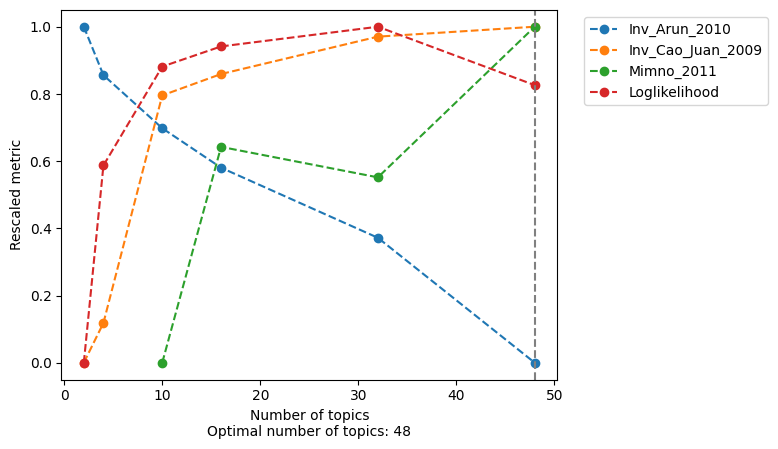

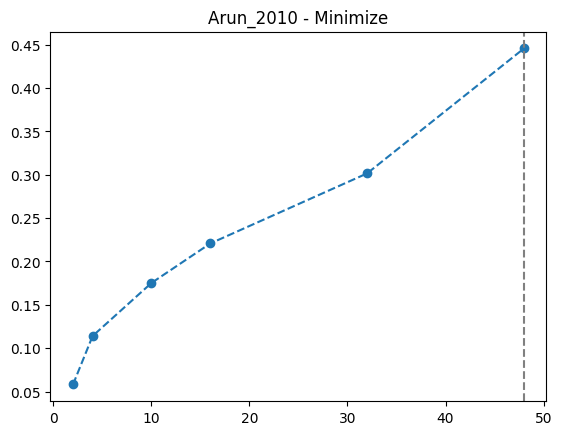

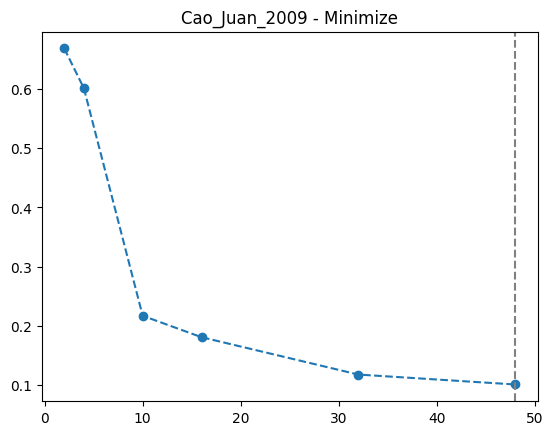

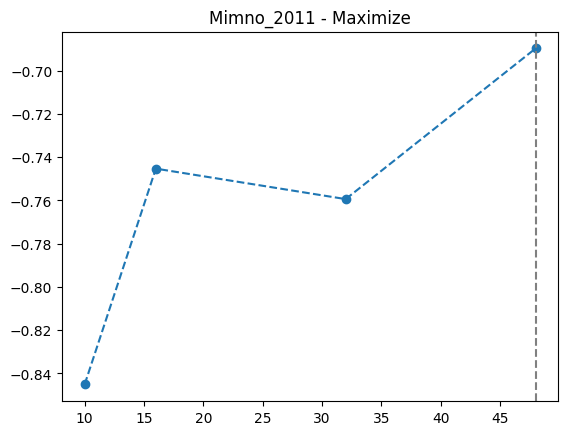

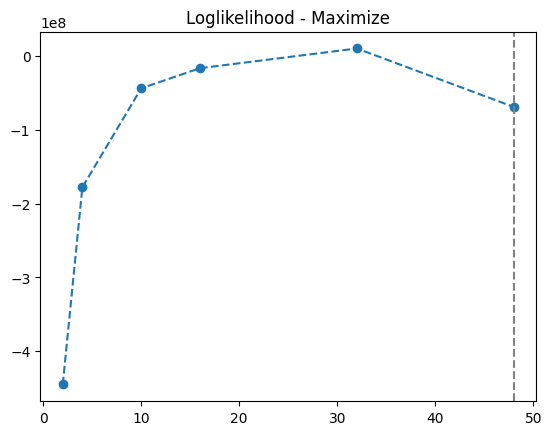

In [47]:
model = evaluate_models(models,
                       select_model=48,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=True)

In [48]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cisTopicObject{}.pkl').format(dataset_suffix), 'wb'))

# 7. Clustering and visualization of cistopics
To review, **cistopics** and differentially accessible regions (DARs) found via scATAC-seq data are SCENIC+'s way of finding putative enhancers. 

A topic in LDA is a collection of "words" (note: sometimes, it's chunks of words...but I digress!). A "cistopic" is assumed to be a collection of genes that have some underlying connection. Therefore, a "cistopic" can be assumed to be a set of nodes (TFs) that have some underlying relation to one another. 

SCENIC+ tactly frames these cistopics as "cell-topic probabilities". These can be used in dimension reduction and cluster visualization.

In [49]:
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix)), 'rb'))
cistopic_obj.add_cell_data(cell_data)
cistopic_obj.cell_data

Columns ['barcode', 'celltype', 'sample_id'] will be overwritten


cisTopic_nr_acc cisTopic_log_nr_frag  \
AGCGATTTCGTCCCAT-1___e12_GSE178546           12631             4.183298   
TCACAGAGTGCTTTGA-1___e12_GSE178546           14031             4.223028   
TACATTCCACTGGGCT-1___e12_GSE178546           13204             4.196646   
CCCAGAGGTGGCGCTT-1___e12_GSE178546           25243             4.524734   
CCAATGAGTCAAATCC-1___e12_GSE178546           31694             4.660363   
...                                            ...                  ...   
CCATACCGTGATGTGG-1___e14_GSE178546            3257             3.533391   
TTCGGTCGTATCTCAG-1___e14_GSE178546            2666             3.446848   
CTACTTATCAGTCTTT-1___e14_GSE178546            3981              3.63729   
TCACAGAAGTTCAACC-1___e14_GSE178546            2550             3.428135   
GACTAGTTCGTGGAAG-1___e14_GSE178546            3591             3.582518   

                                    Total_nr_frag cisTopic_nr_frag  \
AGCGATTTCGTCCCAT-1___e12_GSE178546          64537            15251   
TCACAGAGTGCTTTGA-1___e12_GSE178546          57903            16712   
TACATTCCACTGGGCT-1___e12_GSE178546          73888            15727   
CCCAGAGGTGGCGCTT-1___e12_GSE178546         171571            33476   
CCAATGAGTCAAATCC-1___e12_GSE178546         207491            45747   
...                                           ...              ...   
CCATACCGTGATGTGG-1___e14_GSE178546          11128             3415   
TTCGGTCGTATCTCAG-1___e14_GSE178546          11624             2798   
CTACTTATCAGTCTTT-1___e14_GSE178546          17181             4338   
TCACAGAAGTTCAACC-1___e14_GSE178546           9774             2680   
GACTAGTTCGTGGAAG-1___e14_GSE178546          12634             3824   

                                    TSS_enrichment  Dupl_nr_frag  \
AGCGATTTCGTCCCAT-1___e12_GSE178546       10.744070         40804   
TCACAGAGTGCTTTGA-1___e12_GSE178546       10.678033         31871   
TACATTCCACTGGGCT-1___e12_GSE178546        8.565215         45174   
CCCAGAGGTGGCGCTT-1___e12_GSE178546        9.079323        103891   
CCAATGAGTCAAATCC-1___e12_GSE178546       10.101684        132371   
...                                            ...           ...   
CCATACCGTGATGTGG-1___e14_GSE178546        9.426602          6283   
TTCGGTCGTATCTCAG-1___e14_GSE178546       10.698375          7758   
CTACTTATCAGTCTTT-1___e14_GSE178546       11.449845         10994   
TCACAGAAGTTCAACC-1___e14_GSE178546       11.741667          5584   
GACTAGTTCGTGGAAG-1___e14_GSE178546        9.634504          7225   

                                    Total_nr_frag_in_regions  \
AGCGATTTCGTCCCAT-1___e12_GSE178546                     42815   
TCACAGAGTGCTTTGA-1___e12_GSE178546                     37824   
TACATTCCACTGGGCT-1___e12_GSE178546                     42126   
CCCAGAGGTGGCGCTT-1___e12_GSE178546                     88896   
CCAATGAGTCAAATCC-1___e12_GSE178546                    131346   
...                                                      ...   
CCATACCGTGATGTGG-1___e14_GSE178546                      7841   
TTCGGTCGTATCTCAG-1___e14_GSE178546                      8451   
CTACTTATCAGTCTTT-1___e14_GSE178546                     12302   
TCACAGAAGTTCAACC-1___e14_GSE178546                      6455   
GACTAGTTCGTGGAAG-1___e14_GSE178546                      8926   

                                   Predicted_doublets_fragments      FRIP  \
AGCGATTTCGTCCCAT-1___e12_GSE178546                        False  0.629461   
TCACAGAGTGCTTTGA-1___e12_GSE178546                        False  0.627919   
TACATTCCACTGGGCT-1___e12_GSE178546                        False  0.535592   
CCCAGAGGTGGCGCTT-1___e12_GSE178546                        False  0.485239   
CCAATGAGTCAAATCC-1___e12_GSE178546                        False  0.597244   
...                                                         ...       ...   
CCATACCGTGATGTGG-1___e14_GSE178546                        False  0.683591   
TTCGGTCGTATCTCAG-1___e14_GSE178546                        False  0.707450   
CTACTTATCAGTCT

In [50]:
cistopic_obj.selected_model

2024-04-17 16:17:36,405 cisTopic     INFO     Running UMAP


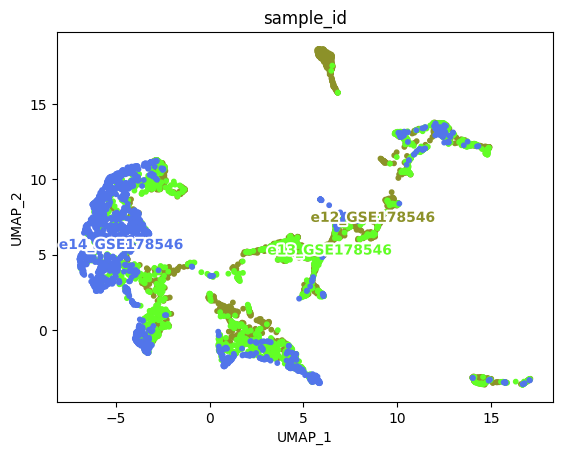

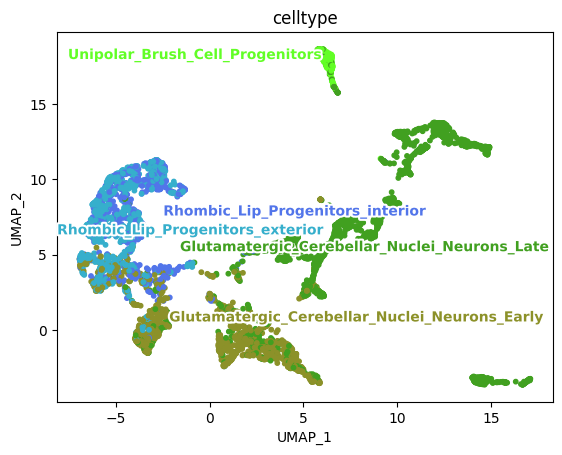

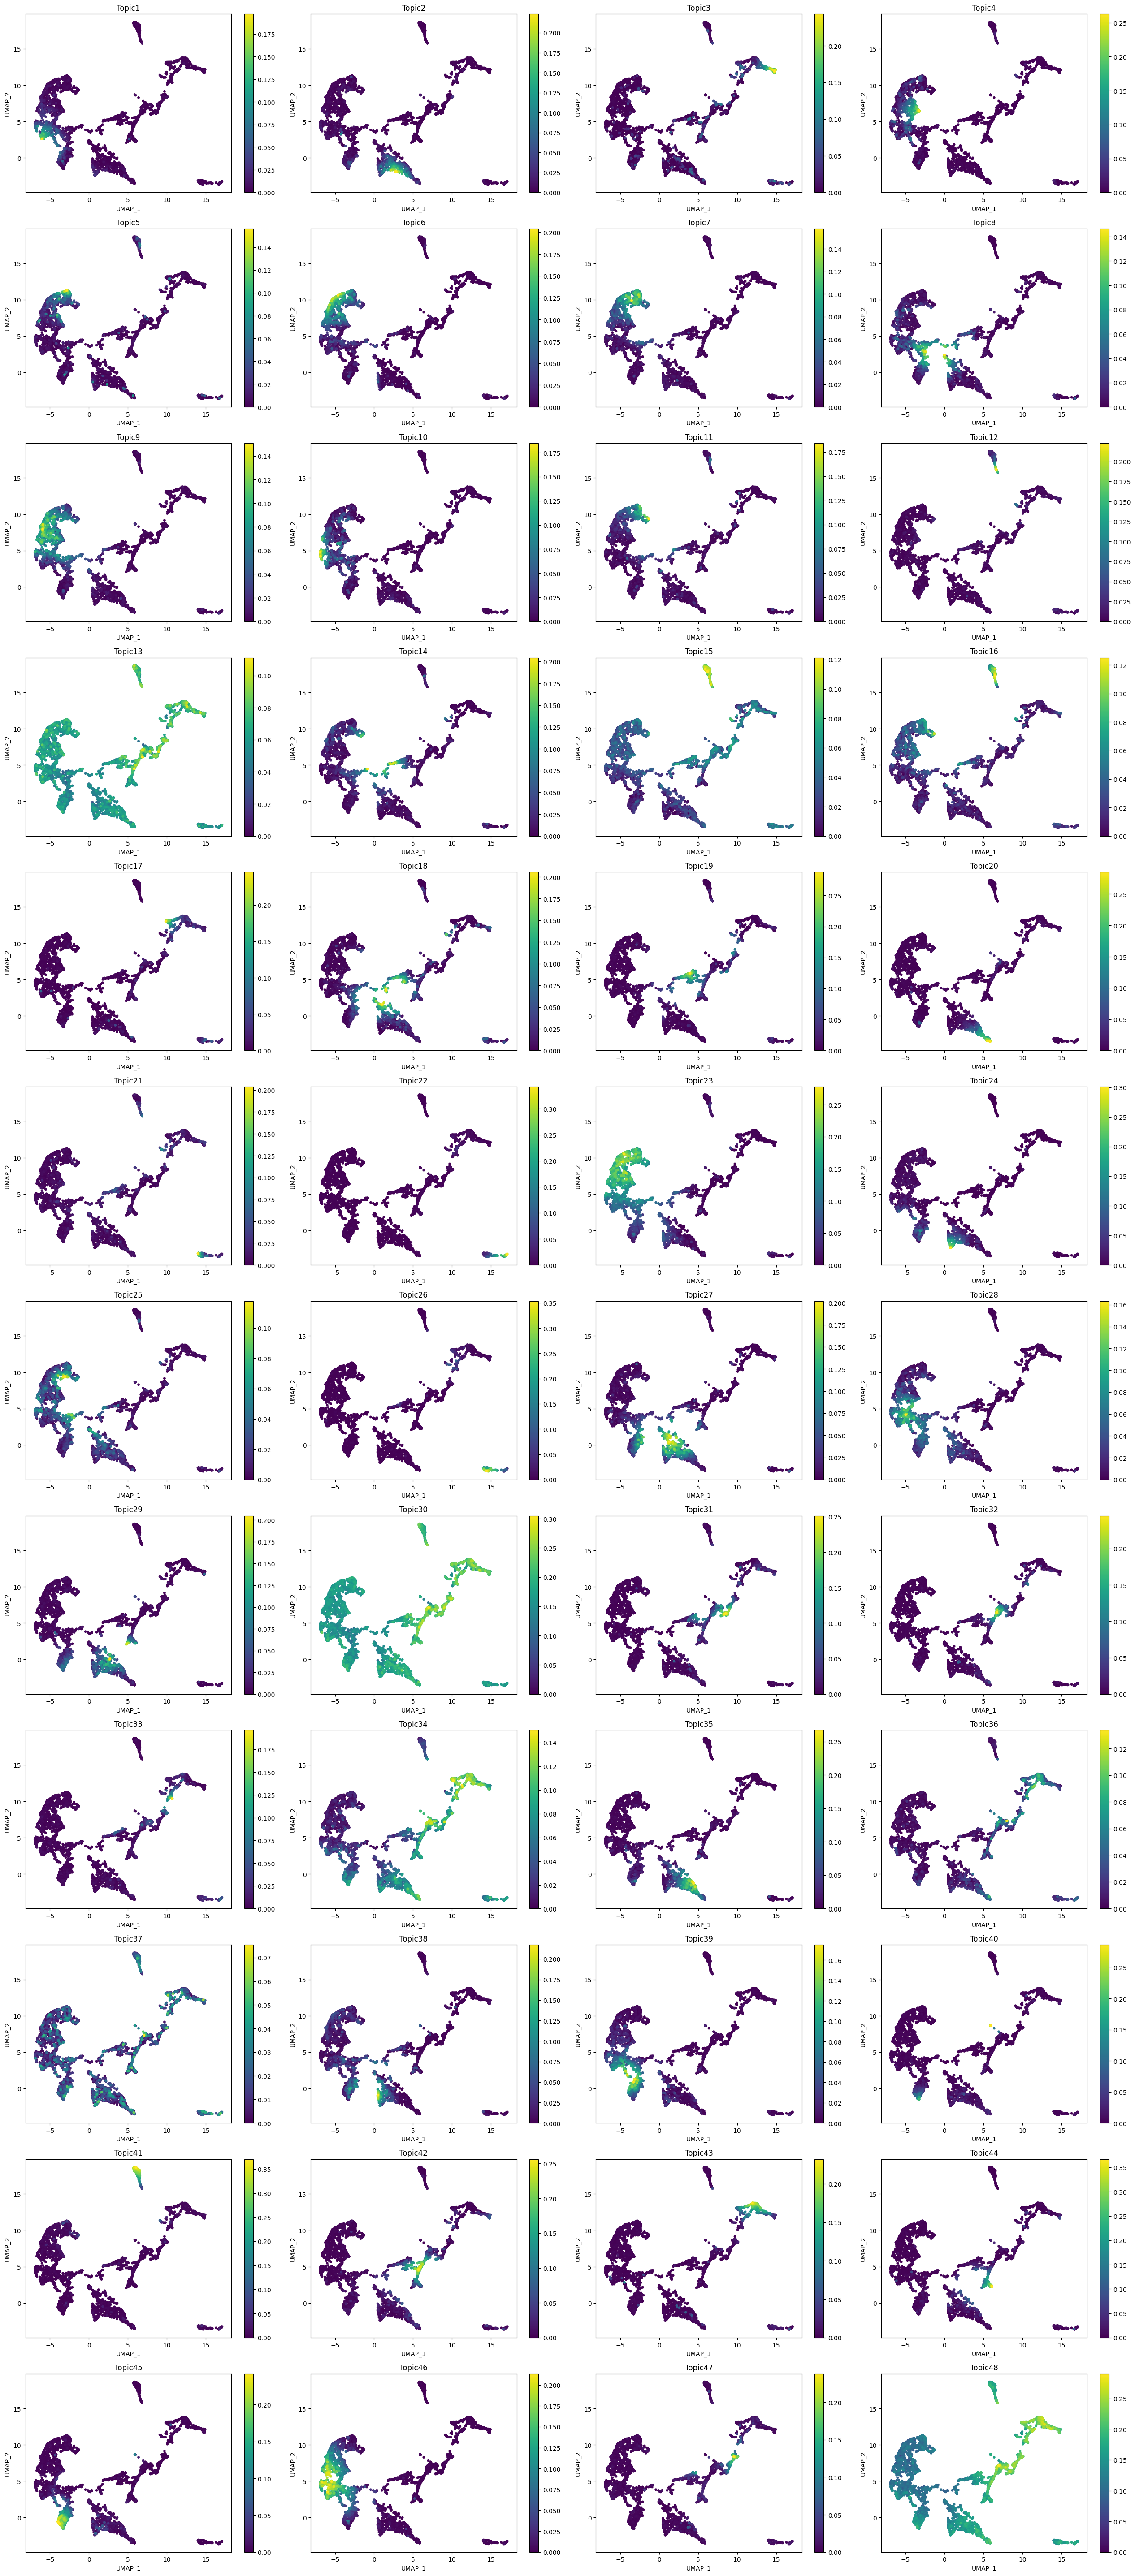

In [51]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target = 'cell', scale=False)

plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['sample_id', 'celltype'])

plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

As a sanity check, visualize batch/timepoint effects (gulp)! 
For this workflow, integration (harmonization) is necessary. 

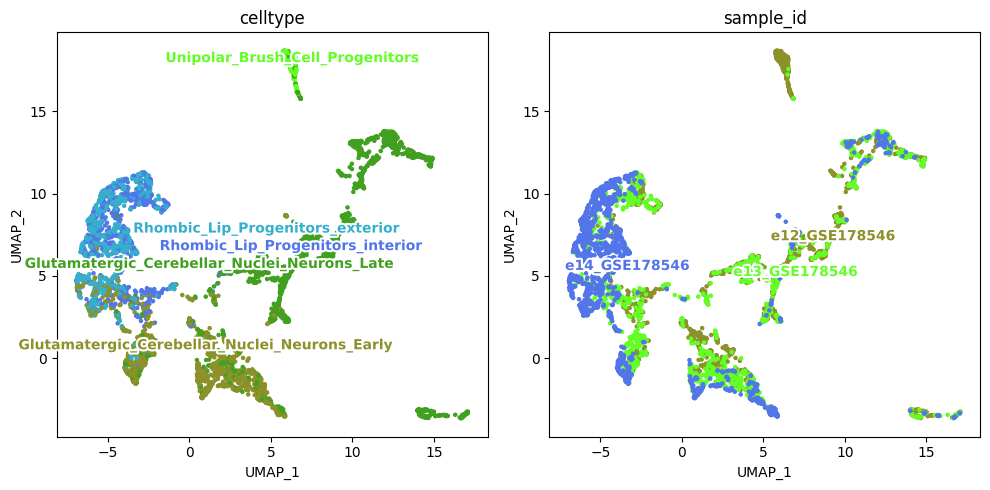

In [53]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['celltype', 'sample_id'], 
                 target='cell', 
                 num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,5),
                 save= work_dir + 'visualization/dimensionality_reduction_label_uncorrected{}.pdf'.format(dataset_suffix))

In [55]:
# Harmony
harmony(cistopic_obj, 
        'sample_id', 
        random_state=555)  
# UMAP
run_umap(cistopic_obj, 
         reduction_name='harmony_UMAP',
         target = 'cell', 
         harmony=True)

2024-04-17 16:19:19,676 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2024-04-17 16:19:19,676 harmonypy    INFO     Computing initial centroids with sklearn.KMeans...


2024-04-17 16:19:21,623 - harmonypy - INFO - sklearn.KMeans initialization complete.


2024-04-17 16:19:21,623 harmonypy    INFO     sklearn.KMeans initialization complete.


2024-04-17 16:19:21,643 - harmonypy - INFO - Iteration 1 of 10


2024-04-17 16:19:21,643 harmonypy    INFO     Iteration 1 of 10


2024-04-17 16:19:22,307 - harmonypy - INFO - Iteration 2 of 10


2024-04-17 16:19:22,307 harmonypy    INFO     Iteration 2 of 10


2024-04-17 16:19:22,970 - harmonypy - INFO - Iteration 3 of 10


2024-04-17 16:19:22,970 harmonypy    INFO     Iteration 3 of 10


2024-04-17 16:19:23,632 - harmonypy - INFO - Converged after 3 iterations


2024-04-17 16:19:23,632 harmonypy    INFO     Converged after 3 iterations
2024-04-17 16:19:23,636 cisTopic     INFO     Running UMAP


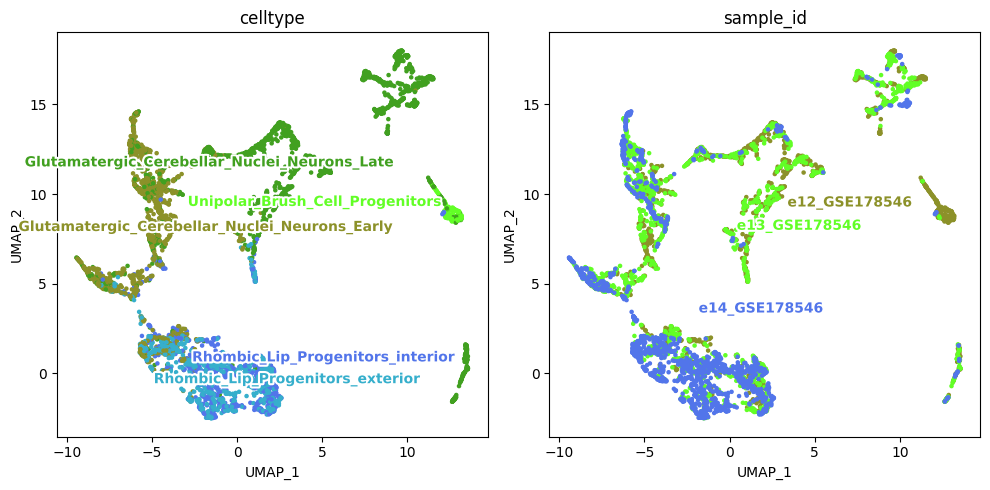

In [56]:
plot_metadata(cistopic_obj,
              reduction_name='harmony_UMAP',
              variables=['celltype', 'sample_id'], # Labels from RNA and new clusters
              target='cell', 
              num_columns=2,
              text_size=10,
              dot_size=5,
              figsize=(10,5),
              save= work_dir + 'visualization/dimensionality_reduction_label_corrected{}.pdf'.format(dataset_suffix))

In [57]:
# Save
with open(work_dir + 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(cistopic_obj, f)

# 8. Inferring candidate enhancer regions by topic binarization
Technically 2 steps: 
1. Binarization of region-topic probabilites (i.e. simplifying data into a vector of 0/1 for efficiency). 
2. Calculation differentially accessibile regions (DARs) per cell type.

Putative enhancer regions will be used for downstream analysis in PyCisTopic motif enrichment search. 

Topic binarization via the **Otsu method** using *only the top 3k regions per topic*. The Otsu method is traditionally used in computer vision. The purpose is to generate a single threshold that can separate pixels between "foreground" and "background" based on their "intensity". In a similar fashion, we need a threshold for these putative regions to be described as either a "0" or "1". 


In [69]:
if not os.path.exists(os.path.join(work_dir, 'topic_binarization')):
    os.makedirs(os.path.join(work_dir, 'topic_binarization'))

In [58]:
# Load
infile = open(work_dir + 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix), 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [59]:
from pycisTopic.topic_binarization import *
# step 1: binarization via otsu method
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [64]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=False, nbins=100)

<Figure size 640x480 with 0 Axes>

In [65]:
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [66]:
topic_qc_metrics.head()

Log10_Assignments  Assignments  Regions_in_binarized_topic  \
Topic1            5.575528       376295                        3000   
Topic2            5.701503       502925                        3000   
Topic3            5.635284       431801                        3000   
Topic4            5.720662       525608                        3000   
Topic5            5.583612       383365                        3000   
Topic6            5.899927       794195                        3000   
Topic7            5.782238       605673                        3000   
Topic8            5.709207       511926                        3000   
Topic9            5.925953       843243                        3000   
Topic10           5.618225       415169                        3000   
Topic11           5.703384       505108                        3000   
Topic12           5.384712       242500                        3000   
Topic13           6.412712      2586496                        3000   
Topic14           5.772495       592236                        3000   
Topic15           6.106587      1278165                        3000   
Topic16           5.899140       792757                        3000   
Topic17           5.549315       354254                        3000   
Topic18           5.921219       834101                        3000   
Topic19           5.727834       534360                        3000   
Topic20           5.705742       507858                        3000   
Topic21           5.550695       355382                        3000   
Topic22           5.607523       405063                        3000   
Topic23           6.423885      2653904                        3000   
Topic24           5.773479       593580                        3000   
Topic25           5.784344       608617                        3000   
Topic26           5.751298       564024                        3000   
Topic27           6.037281      1089635                        3000   
Topic28           5.899264       792983                        3000   
Topic29           5.826217       670220                        3000   
Topic30           6.892719      7811225                        3000   
Topic31           5.654113       450934                        3000   
Topic32           5.562081       364822                        3000   
Topic33           5.464981       291730                        3000   
Topic34           6.330068      2138295                        3000   
Topic35           5.922058       835714                        3000   
Topic36           5.744891       555765                        3000   
Topic37           5.798019       628086                        3000   
Topic38           5.828396       673591                        3000   
Topic39           5.833136       680982                        3000   
Topic40           5.537161       344478                        3000   
Topic41           5.873551       747397                        3000   
Topic42           5.760896       576629                        3000   
Topic43           5.706990       509319                        3000   
Topic44           5.728694       535419                        3000   
Topic45           5.825610       669284                        3000   
Topic46           6.150779      1415075                        3000   
Topic47           5.566632       368665                        3000   
Topic48           6.835471      6846543                        3000   

         Cells_in_binarized_topic  Coherence  Marginal_topic_dist  Gini_index  
Topic1                        430  -1.705156             0.007938    0.814690  
Topic2                        454  -1.374212             0.010578    0.825704  
Topic3                        248  -1.806271             0.009096    0.853431  
Topic4                        489  -1.427308             0.011039    0.838834  
Topic5                        475  -1.812489             0.008087    0.768720  
Topic6                        981  -1.250840     

Create a temporary dictionary for storing figures. 

"Good" topics have high coherence, high number of assignments, and a high marginal topic score (note: these measures are correlated), while being cell-type specific (high Gini index, traditionally indicating greater inequality in economics!).

"Bad" topics have low number of assignments while also being assigned to many cells with low coherence.

In [67]:
fig_dict = {}

fig_dict['CoherenceVSAssignments'] = plot_topic_qc(topic_qc_metrics, 
                                                 var_x='Coherence', 
                                                 var_y='Log10_Assignments', 
                                                 var_color='Gini_index', 
                                                 plot=False, 
                                                 return_fig=True)

fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(topic_qc_metrics, 
                                                    var_x='Log10_Assignments', 
                                                    var_y='Cells_in_binarized_topic', 
                                                    var_color='Gini_index',
                                                    plot=False, 
                                                    return_fig=True)

fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(topic_qc_metrics, 
                                                  var_x='Coherence', 
                                                  var_y='Cells_in_binarized_topic', 
                                                  var_color='Gini_index', 
                                                  plot=False, 
                                                  return_fig=True)

fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(topic_qc_metrics, 
                                                    var_x='Coherence', 
                                                    var_y='Regions_in_binarized_topic', 
                                                    var_color='Gini_index',
                                                    plot=False, 
                                                    return_fig=True)

fig_dict['CoherenceVSMarginal_dist'] = plot_topic_qc(topic_qc_metrics, 
                                                   var_x='Coherence', 
                                                   var_y='Marginal_topic_dist', 
                                                   var_color='Gini_index', 
                                                   plot=False, 
                                                   return_fig=True)

fig_dict['CoherenceVSGini_index'] = plot_topic_qc(topic_qc_metrics, 
                                                var_x='Coherence', 
                                                var_y='Gini_index', 
                                                var_color='Gini_index', 
                                                plot=False, 
                                                return_fig=True)

In [70]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) # To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(work_dir + 'topic_binarization/Topic_qc{}.pdf'.format(dataset_suffix), bbox_inches='tight')
plt.show()

### Automatic topic annotation by cell type. 
Proportion of cells in each group that are assigned to the binarized topic in comparison to the ratio in the whole data set. 

"General" topic: If the difference between the ratio of cells in the whole data set in the binarized topic and the ratio of total cells in the assigned groups is above 0.2. 
- The propotion test may fail if the topic is enriched in both foreground (the group) and background (the whole data set); resulting in a big difference between the ratios.

Finally, merge topic metrics and their annotation into data frame.

In [71]:
topic_annot = topic_annotation(cistopic_obj, 
                               annot_var='celltype', 
                               binarized_cell_topic=binarized_cell_topic, 
                               general_topic_thr = 0.2)
# topic_annot

celltype  \
Topic1   Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic2       Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic3        Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic4   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic5   Unipolar_Brush_Cell_Progenitors, Rhombic_Lip_P...   
Topic6   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic7   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic8   Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic9   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic10  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic11  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic12                    Unipolar_Brush_Cell_Progenitors   
Topic13  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   
Topic14                   Rhombic_Lip_Progenitors_interior   
Topic15  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   
Topic16  Unipolar_Brush_Cell_Progenitors, Rhombic_Lip_P...   
Topic17       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic18  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic19       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic20      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic21       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic22       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic23  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic24      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic25  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic26       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic27      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic28  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic29      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic30  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   
Topic31       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic32       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic33       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic34  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic35      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic36       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic37  Unipolar_Brush_Cell_Progenitors, Rhombic_Lip_P...   
Topic38      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic39  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic40      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic41                    Unipolar_Brush_Cell_Progenitors   
Topic42       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic43       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic44       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic45      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic46  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic47       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic48  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1              0.085983                  0.404719       False  
Topic2              0.090782                  0.239752       False  
Topic3               0.04959                  0.387922       False  
Topic4               0.09778                  0.338532       False  
Topic5              0.094981                  0.372326       False  
Topic6              0.196161                  0.338532       False  
Topic7              0.173565                  0.338532       False  
Topic8              0.110578                  0.413317       False  
Topic9              0.277944                  0.338532       False  
Topic10             0.090182                  0.338532       False  
Topic11             0.114977                  0.338532       False  
Topic12             0.019996                  0.033793       False  
Topic13             0.394521                  0.421716       False  
Topic14             0.108178                 

In [72]:
topic_qc_metrics = pd.concat([topic_annot[['celltype', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], topic_qc_metrics], axis=1)
topic_qc_metrics

celltype  \
Topic1   Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic2       Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic3        Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic4   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic5   Unipolar_Brush_Cell_Progenitors, Rhombic_Lip_P...   
Topic6   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic7   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic8   Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic9   Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic10  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic11  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic12                    Unipolar_Brush_Cell_Progenitors   
Topic13  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   
Topic14                   Rhombic_Lip_Progenitors_interior   
Topic15  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   
Topic16  Unipolar_Brush_Cell_Progenitors, Rhombic_Lip_P...   
Topic17       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic18  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic19       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic20      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic21       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic22       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic23  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic24      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic25  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic26       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic27      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic28  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic29      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic30  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   
Topic31       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic32       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic33       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic34  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic35      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic36       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic37  Unipolar_Brush_Cell_Progenitors, Rhombic_Lip_P...   
Topic38      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic39  Glutamatergic_Cerebellar_Nuclei_Neurons_Early,...   
Topic40      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic41                    Unipolar_Brush_Cell_Progenitors   
Topic42       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic43       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic44       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic45      Glutamatergic_Cerebellar_Nuclei_Neurons_Early   
Topic46  Rhombic_Lip_Progenitors_interior, Rhombic_Lip_...   
Topic47       Glutamatergic_Cerebellar_Nuclei_Neurons_Late   
Topic48  Unipolar_Brush_Cell_Progenitors, Glutamatergic...   

        Ratio_cells_in_topic Ratio_group_in_population  Log10_Assignments  \
Topic1              0.085983                  0.404719           5.575528   
Topic2              0.090782                  0.239752           5.701503   
Topic3               0.04959                  0.387922           5.635284   
Topic4               0.09778                  0.338532           5.720662   
Topic5              0.094981                  0.372326           5.583612   
Topic6              0.196161                  0.338532           5.899927   
Topic7              0.173565                  0.338532           5.782238   
Topic8              0.110578                  0.413317           5.709207   
Topic9              0.277944                  0.338532           5.925953   
Topic10             0.090182                  0.338532           5.618225   
Topic11             0.114977                  0.338532           5.703384   
Topic12             0.019996                  0.033793           5.384712   
Topic13   

In [81]:
# Save
with open(work_dir + 'topic_binarization/Topic_qc_metrics_annot{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(work_dir + 'topic_binarization/region_bin_topics_otsu{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(region_bin_topics_otsu, f)
with open(work_dir + 'topic_binarization/binarized_cell_topic{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(work_dir + 'topic_binarization/binarized_topic_region_top3k{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(region_bin_topics_top3k, f)

Calculate DARs per cell type. 
In the first imputation step, very low probability values are shrunk to 0 using a scale factor (by default: 10^6)
Imputed data is log-normalized, then highly-variable regions will be identified to speed up hypothesis testing for DAR search. 

In [75]:
# Load cisTopic object
infile = open(work_dir + 'scATAC/cisTopicObject{}.pkl'.format(dataset_suffix), 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [76]:
from pycisTopic.diff_features import *
# step 2: compute DARs
imputed_acc_obj = impute_accessibility(cistopic_obj, 
                                       selected_cells=None, 
                                       selected_regions=None, 
                                       scale_factor=10**6)

normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, 
                                              scale_factor=10**4)

variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, 
                                                 plot = False)

markers_dict = find_diff_features(cistopic_obj, 
                                  imputed_acc_obj, 
                                  variable='celltype', 
                                  var_features=variable_regions)


2024-04-17 19:54:17,788 cisTopic     INFO     Imputing region accessibility
2024-04-17 19:54:17,789 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-04-17 19:54:18,367 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-04-17 19:54:18,948 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-04-17 19:54:19,529 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-04-17 19:54:20,112 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-04-17 19:54:20,694 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-04-17 19:54:21,274 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-04-17 19:54:21,856 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-04-17 19:54:22,439 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-04-17 19:54:23,022 cisTopic     

<Figure size 640x480 with 0 Axes>

In [77]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

Glutamatergic_Cerebellar_Nuclei_Neurons_Early: 21633
Glutamatergic_Cerebellar_Nuclei_Neurons_Late: 21173
Rhombic_Lip_Progenitors_exterior: 25363
Rhombic_Lip_Progenitors_interior: 24723
Unipolar_Brush_Cell_Progenitors: 9567


In [79]:
if not os.path.exists(os.path.join(work_dir, 'DARs')):
    os.makedirs(os.path.join(work_dir, 'DARs'))

In [80]:
# Save
with open(work_dir + 'DARs/Imputed_accessibility{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(imputed_acc_obj, f)

with open(work_dir + 'DARs/DARs{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(markers_dict, f)

with open(work_dir + 'DARs/variable_regions{}.pkl'.format(dataset_suffix), 'wb') as f:
  pickle.dump(variable_regions, f)